*Multi-class dog breed classification*

This notebook builds an end-to-end multi-class image classifier using Tensorflow 2.0 and Tensorflow Hub.

1. **Problem** 

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

2. **Data**

The data we're using is from Kaggle's dog breed identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

3. **Evaluation**

The evaluation is a file with prediction probabilities for each dog breed of each image.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

4. **Features**

Some information about the data:
*We're dealing with images (unstructed data) so it's probably best we use deep learning / transfer learning.
*There are 120 breeds of dogs (this means there are 120 diffrent classes). 
*There  are around 10.000+ images in the training set (this images have labels).
*There are around 10.000 images in the test set (this images have no labels, because we'll want to predict them).





# Get our workspace ready

In [ ]:
#  !unzip "/content/drive/MyDrive/Colab Notebooks/data/dog-breed-identification.zip" -d "drive/MyDrive/Colab Notebooks/data/"
# # -d comes from destination

In [ ]:
# import necessary tools
import tensorflow as tf 
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)

TF version:  2.6.0
TF Hub version:  0.12.0


In [ ]:


# code needs to run on a GPU for really fast numerical calculation
# check for gpu availability in colab, make sure you have hardware accelerator set to GPU in notebook settings  
print("GPU is available" if tf.config.list_physical_devices("GPU") else "not available")


GPU is available


Getting data ready (turning into tensors)

With all ML models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors(numerical representations).


In [ ]:
# access the data and checking out the labels
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head(5))

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     93660caa9d048421c2ce42040b1b3e7d  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


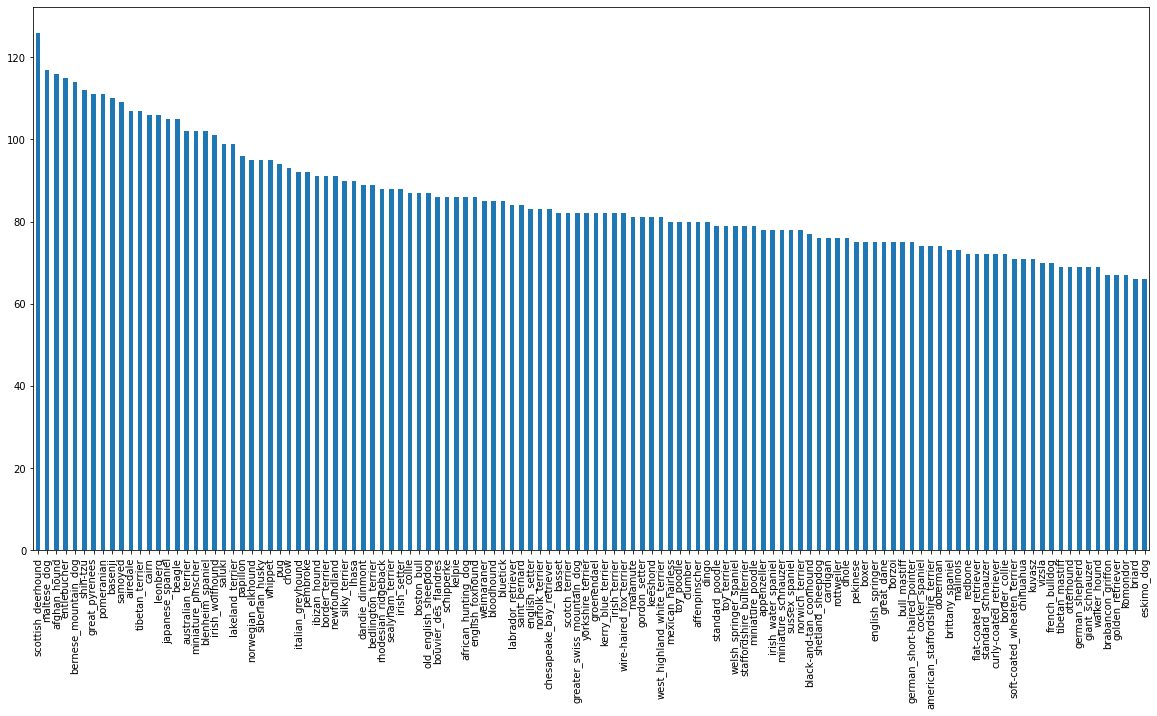

In [ ]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10));

In [ ]:
labels_csv['breed'].value_counts().median()

82.0

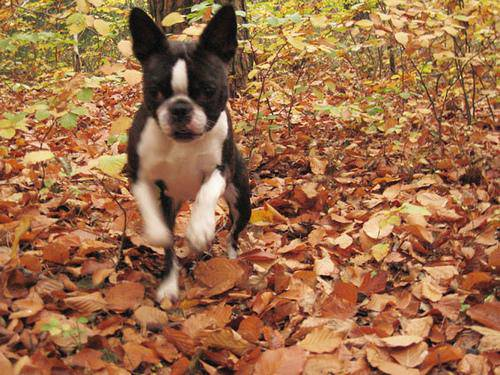

In [ ]:
# view an image
from IPython.display import Image
Image("drive/My Drive/Colab Notebooks/data/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

Let's get a list of our image file pathnames

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# create pathnames from image ID's
filenames = ["drive/My Drive/Colab Notebooks/data/train/" + fname + ".jpg" for fname in labels_csv['id']]
filenames[:10]

['drive/My Drive/Colab Notebooks/data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Colab Notebooks/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Colab Notebooks/data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Colab Notebooks/data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Colab Notebooks/data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Colab Notebooks/data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Colab Notebooks/data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Colab Notebooks/data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Colab Notebooks/data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Colab Notebooks/data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# check wheter number pf filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Colab Notebooks/data/train/")) == len(filenames):
  print("Filenames match acutual amount of images")

else:
  raise ValueError("Amount of images is not equal")

Filenames match acutual amount of images


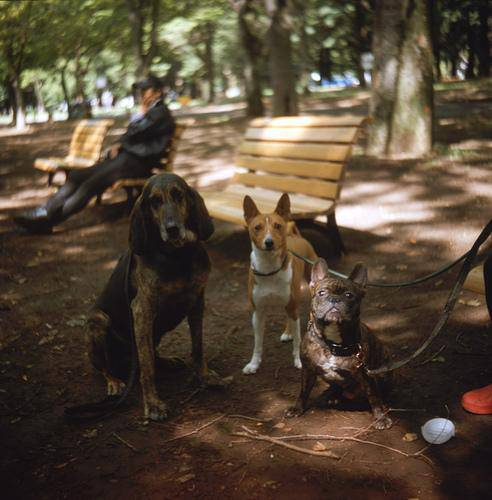

In [ ]:
# one more check
Image(filenames[9814])

In [ ]:
labels_csv['breed'][9814]

'basenji'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # do the same thing as above
labels, len(labels)

(array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
        'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object),
 10222)

In [ ]:
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
   print("Number of labels does not match the number of filenames")

Number of labels matches number of filenames


In [ ]:
import numpy as np


In [ ]:
# find the unique label values
unique_breeds = np.unique(labels)
unique_breeds, len(unique_breeds)

(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter', 'gre

In [ ]:
# turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2], len(boolean_labels)

([array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False]),
  array([False, False, False, Fa

In [ ]:
# example of turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


Creating our own validation set.

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [ ]:
# setup X and y variables
X = filenames
y = boolean_labels


We're going to start off experimenting with ~1000 images and increse as needed

In [ ]:
# set number of images to use for experimenting 
NUM_IMAGES = 1000 #@param {type:"slider", min:0, max:10000, step:1000}

In [ ]:
# split our data into train and validation sets
from sklearn.model_selection import train_test_split

# split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,# actually this is validation
                                                  random_state = 42)
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [ ]:
X_train[:2], y_train[:2]

(['drive/My Drive/Colab Notebooks/data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Colab Notebooks/data/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, Fa

Preprocessing images(turning images/data into tensors/numerical representation).

To preprocess our images into tensors we're going o write a funtion which does a few things:
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable 'image'
3. Turn our 'image', a jpg, into tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
4. Resize the 'image' to be a shape of (224,224)
5. Return the modified 'image'

In [ ]:
# convert an image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [ ]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [ ]:
# Define image size
IMG_SIZE = 224
# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a tensor.
  """
  # Read in a image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numeriacal tensor with 3 colour channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

Turning our data into batches

Why?
Well if we try to process 10.000+ images in one go, they all might not fit into memory. So that's why we do about 32 images at a time (batch size(images in our case) = 32 being the default value).

In order to use Tensorflow effectively, we need our data in the form of tensor tuple which look like this: " (image, label) ".

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the asociated label,
  processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Demo
process_image(X[42]
              , tf.constant(y[42]))

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, 
                        valid_data = False, test_data = False):
  """
  Creates batches of data out of image (X) and a label (y) pairs.
  Shuffles the data if its the training data, but doesn't shuffle if its the validation data.
  Also accepts test_data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images 
    data = data.shuffle(buffer_size = len(X)) 

    # Create (image, label) tuple (this also turns the image path into a preprocess image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch

# New Section

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the diffrent attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [ ]:
len(y[0])

120

Visualizing Data Batches

In [ ]:
import matplotlib.pyplot as plt
# Creating a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5,i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [ ]:
%%time
train_images, train_labels = next(train_data.as_numpy_iterator())


CPU times: user 141 ms, sys: 94.3 ms, total: 236 ms
Wall time: 195 ms


In [ ]:
len(train_images), len(train_labels)

(32, 32)

remember our batch size is 32

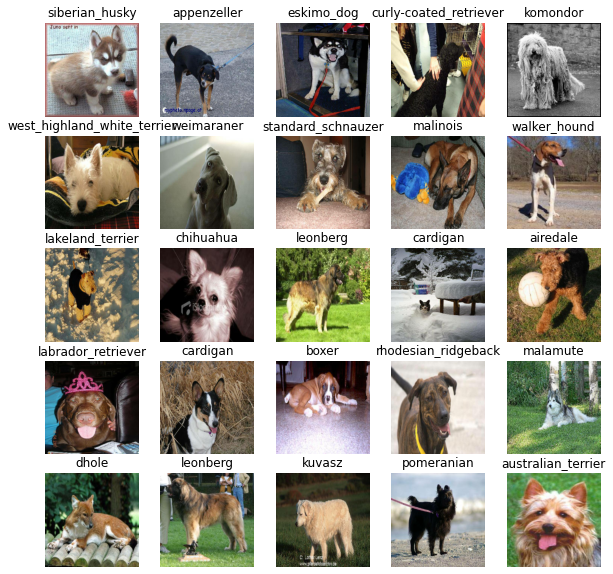

In [ ]:
# Viewing the data in a training batch
show_25_images(train_images, train_labels)

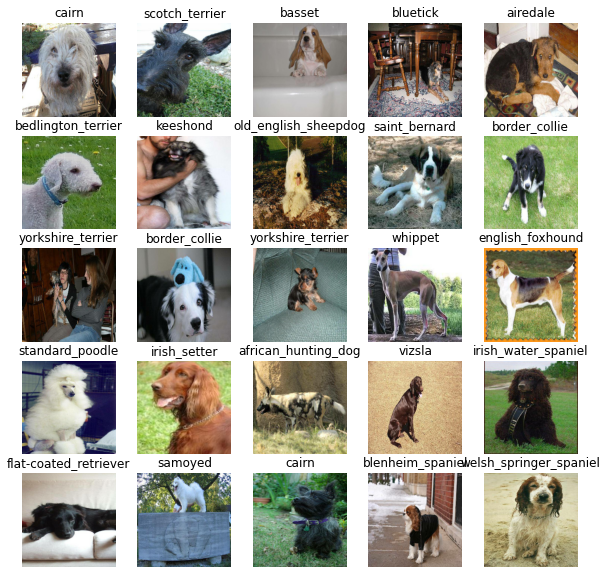

In [ ]:
# viewing the validtion batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

Building a model.
Before we build a model, there are few things we need to define:
1. The input shape (our image shape, in the form of Tensors) to our model.
2. The output shape (image labels, in the form of Tensors) of our model.
3. The url of the model we want to use. 

In [ ]:
# Setup the image shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup the output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"


Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras Deep Learning model.
Knowing this let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE,
                 output_shape=OUTPUT_SHAPE,
                 model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation='softmax') #layer 2 (output layer)
])
  
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam( ),
      metrics=['accuracy']
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


#Creating Callbacks.
#Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our progress and another for early stopping which prevents our model from training for too long.


TensorBoard Callback

To setup a Tensorboard callback, we need to do 3 things:
1. Load the Tensorboard notebook extension;
2. Create a Tensorboard callback which is able to save logs to a directory and pass it to our model's 'fit()' function;
3. Visualize our models training logs with the '%tensorboard' magic function.






In [ ]:
# Load tensorboard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
# Create a function to buils a Tensorboard callback

def create_tensorboard_callback():
  # Create a log directory for storing Tensorboard logs
  logdir = os.path.join("/content/drive/MyDrive/Colab Notebooks/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir) 

Early stopping callback.

Early stopping helps stop our model from overfittng by stopping training if a certainevaluation metric stops improving

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

###Training a model (on subset of data).

Our first model is only going to train on 1000 images, to make sure everything is working.

In [ ]:
NUM_EPOCHS = 10 #@param {type:'slider', min:10, max:100, step:10}


Let's create a function which trains a model.

*Create a model using 'create_model()';
*Setup a Tensorboard callback using 'create_tensorboard_callback()';
*Call the 'fit()' function on our model passing it the training data, validation data, number of epochs to train for '(NUM_EPOCHS)' and the callbacks we'd like to use;
*Return the model

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new Tensorboard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping]
            )
  # Return the fitted model
  return model

In [ ]:
# fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/10
25/25 [==============================] - 105s 4s/step - loss: 4.5311 - accuracy: 0.1125 - val_loss: 3.2829 - val_accuracy: 0.2650
Epoch 2/10
25/25 [==============================] - 5s 181ms/step - loss: 1.6562 - accuracy: 0.6712 - val_loss: 2.1322 - val_accuracy: 0.5250
Epoch 3/10
25/25 [==============================] - 4s 167ms/step - loss: 0.5745 - accuracy: 0.9275 - val_loss: 1.6670 - val_accuracy: 0.5800
Epoch 4/10
25/25 [==============================] - 4s 169ms/step - loss: 0.2627 - accuracy: 0.9862 - val_loss: 1.4877 - val_accuracy: 0.6500
Epoch 5/10
25/25 [==============================] - 4s 166ms/step - loss: 0.1500 - accuracy: 0.9975 - val_loss: 1.3996 - val_accuracy: 0.6550
Epoch 6/10
25/25 [==============================] - 4s 167ms/step - loss: 0.1035 - accuracy: 1.0000 - val_loss: 1.3504 - val_accuracy: 0.6650
Epoch 7/10
25/25 [==============================] - 5s 1

Looks like our model is overfitted because it's performing far better on the training dataset than the validation dataset, we need some ways to prevent model overfitting in deep learning neural networks.

Checking the tensorboard logs.

the tensorboard magic function '%tensorboard' will access the logs directory we created earlier and visualize its contents.


In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Colab\ Notebooks/logs

Reusing TensorBoard on port 6006 (pid 655), started 0:15:05 ago. (Use '!kill 655' to kill it.)

<IPython.core.display.Javascript object>

Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data (not used to trained on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 5s 114ms/step


array([[5.9200446e-03, 1.3792541e-04, 9.1414910e-04, ..., 1.6195397e-03,
        8.1364975e-05, 1.9271250e-03],
       [3.6282702e-03, 5.8696978e-04, 3.3465572e-02, ..., 7.6118123e-04,
        1.2685381e-03, 4.3326049e-04],
       [1.5274990e-04, 5.7556876e-04, 4.3792432e-05, ..., 1.0174619e-04,
        9.5454813e-04, 2.7039481e-04],
       ...,
       [9.3802701e-06, 7.0178336e-05, 2.4177538e-05, ..., 5.3303215e-06,
        6.4850952e-05, 2.3788707e-04],
       [1.0101603e-02, 4.0474866e-04, 3.2417884e-04, ..., 2.3900668e-04,
        9.5631847e-05, 1.0377003e-02],
       [2.0831876e-04, 9.5314630e-05, 5.1522843e-04, ..., 1.6261484e-03,
        4.0824813e-04, 2.4753818e-04]], dtype=float32)

In [ ]:
predictions.shape

(200, 120)

In [ ]:
len(y_val), len(unique_breeds)

(200, 120)

In [ ]:
# Firts prediction
index = 1
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[3.3842519e-04 2.0227562e-04 2.0283176e-02 4.8629534e-03 8.3024759e-04
 8.7525557e-05 1.5715679e-02 2.0160803e-03 7.6829841e-05 3.7869974e-04
 4.7701941e-04 6.0514252e-05 6.0210303e-05 5.3546541e-05 1.5771241e-04
 2.5037795e-04 9.5243612e-03 1.6352865e-04 3.0754908e-04 2.8445703e-04
 1.2734019e-03 2.0818734e-04 1.3763086e-04 7.1215138e-05 7.6885626e-04
 1.2468015e-04 1.1425690e-01 8.2476726e-03 4.6511213e-05 8.8641274e-04
 8.7788561e-05 1.7822771e-04 5.3498207e-04 4.3885717e-05 1.7150292e-04
 7.3006970e-04 7.1065483e-04 4.5002750e-03 6.8033108e-04 2.3233053e-05
 6.7503960e-04 3.7204908e-04 7.0432128e-05 1.6623798e-03 6.5854698e-04
 5.7583689e-03 7.5124810e-04 2.5982180e-04 6.9472045e-02 3.4220338e-05
 1.3843729e-04 4.8321183e-04 7.9586673e-05 1.3008168e-04 1.8513239e-03
 4.0719300e-03 8.3028586e-05 2.7217455e-02 1.9451441e-03 4.7799321e-03
 1.8702800e-03 1.8713163e-05 1.3877609e-04 2.4813575e-05 5.2951504e-03
 2.9363197e-05 1.2646675e-04 1.3562050e-03 2.0236292e-04 3.7062422e-05
 1.288

Having the above functionality is great but we want to be able to do it at scale.
And it would be even better if we could see the image the predictions is being made on.

**Note: predictions probabilities are also known as  confidence levels.**

In [ ]:
# Turn predictions probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of preditions probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of predictions probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'irish_wolfhound'

In [ ]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictionsto the validation labels (true labels).



In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
  """
  images_ = []
  labels_ = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(unique_breeds[np.argmax(label)])

  return images_, labels_

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Let's make some function to make {Prediction labels, validation labels, validation images} a bit more visual.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and integers.

* Convert the prediction probabilities to a predicted label.

* Plot the predicted label, it's predicted probability, the truth label and the target image on a single plot.

In [ ]:
 def plot_pred(prediction_probabilities, labels, images, n=1):
   """
   View the prediction, ground truth and image for sample n
   """
   pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

   # Get the pred label
   pred_label = get_pred_label(pred_prob)

   # Plot image & remove ticks
   plt.imshow(image)
   plt.xticks([])
   plt.yticks([])

   # Change the colour of the title depending on if the prediction is right or not
   if pred_label == true_label:
     color = "green"
   else:
       color = "red"

   # Change plot title to be predicted, probability of prediction and truth label
   plt.title("{} {:2.0f}% {}".format(pred_label,
                                     np.max(pred_prob)*100,
                                     true_label),
                                     color = color)
   


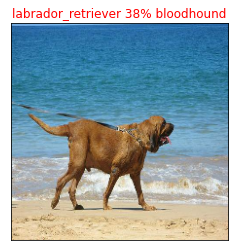

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels = val_labels,
          images = val_images,
          n=100)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.
This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer;
* Find the prediction using get_pred_label();
* Find the top 10 (prediction probabilities indexes, values, and prediction labels);
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                        top_10_pred_values,
                        color = "grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation = "vertical")
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
      pass


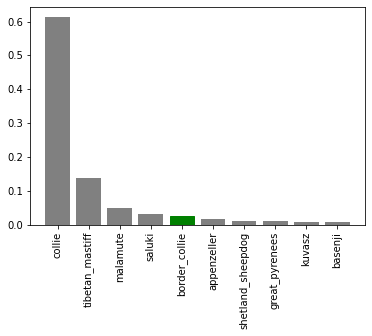

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


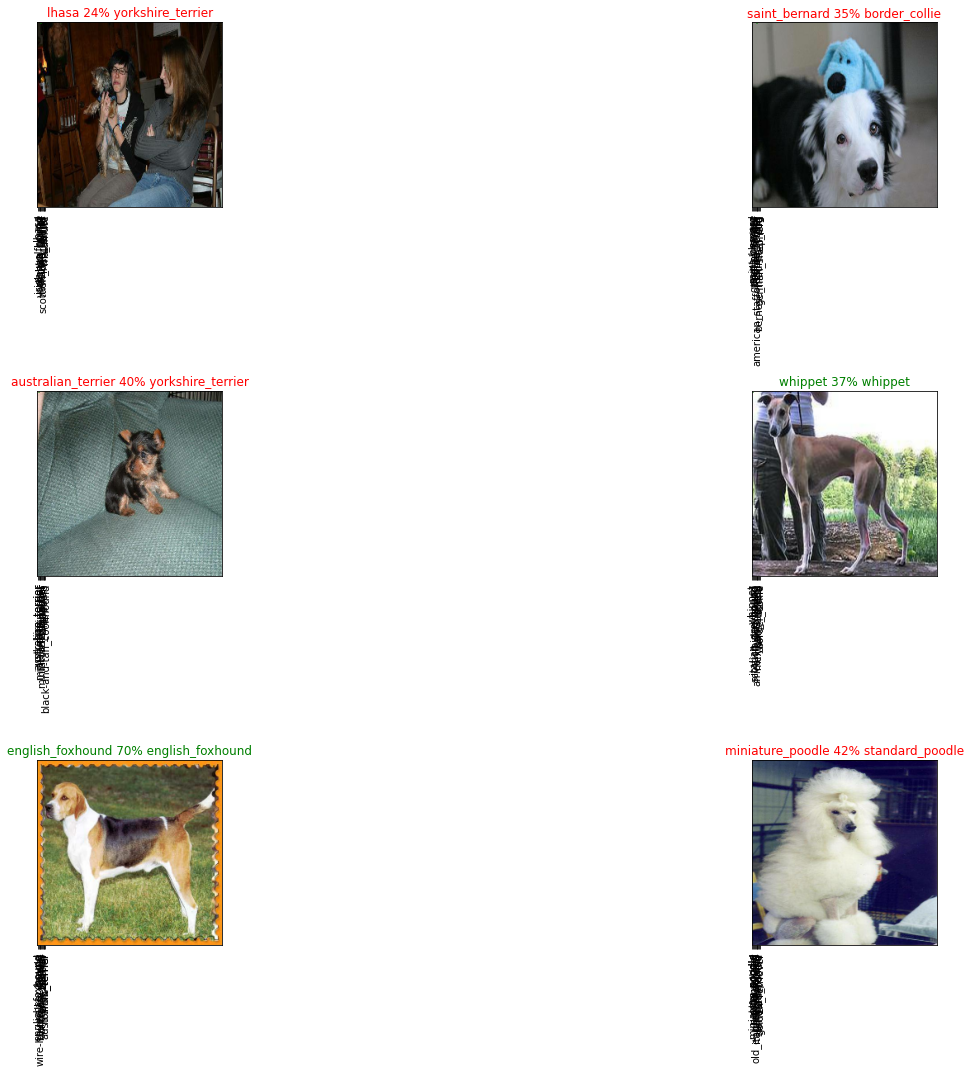

In [ ]:
# Let's check out a few predictions and their diffrent values
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
             labels=val_labels,
             images=val_images,
             n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

Save and reload a trained model

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("/content/drive/MyDrive/Colab Notebooks/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s") 
                          )
  model_path = modeldir + "-" + ".h5"  # save format of the model
  print(f"Saving model to: {model_path}")
  model.save(model_path)
  return model_path


In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a seved model from a specified path.
  """
  print(f"Loading saved model from:{model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: /content/drive/MyDrive/Colab Notebooks/models/20211014-09041634202245-.h5


'/content/drive/MyDrive/Colab Notebooks/models/20211014-09041634202245-.h5'

In [ ]:
# Load a trained model
load_1000_image_model = load_model("/content/drive/MyDrive/Colab Notebooks/models/20211012-14531634050420-.h5")

Loading saved model from:/content/drive/MyDrive/Colab Notebooks/models/20211012-14531634050420-.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 113ms/step - loss: 1.3013 - accuracy: 0.6550


[1.3013107776641846, 0.6549999713897705]

In [ ]:
# Evaluate the loaded model
load_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 106ms/step - loss: 1.3920 - accuracy: 0.6200


[1.3919703960418701, 0.6200000047683716]

Training on full data

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
# create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor valdation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while (maybe up to 30 minutes for the  first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                         full_model_early_stopping])

Epoch 1/10
320/320 [==============================] - 1372s 4s/step - loss: 1.3556 - accuracy: 0.6706
Epoch 2/10
320/320 [==============================] - 40s 126ms/step - loss: 0.4043 - accuracy: 0.8803
Epoch 3/10
320/320 [==============================] - 40s 125ms/step - loss: 0.2384 - accuracy: 0.9359
Epoch 4/10
320/320 [==============================] - 39s 123ms/step - loss: 0.1540 - accuracy: 0.9638
Epoch 5/10
320/320 [==============================] - 40s 123ms/step - loss: 0.1047 - accuracy: 0.9796
Epoch 6/10
320/320 [==============================] - 40s 124ms/step - loss: 0.0777 - accuracy: 0.9873
Epoch 7/10
320/320 [==============================] - 40s 124ms/step - loss: 0.0596 - accuracy: 0.9919
Epoch 8/10
320/320 [==============================] - 40s 125ms/step - loss: 0.0459 - accuracy: 0.9945
Epoch 9/10
320/320 [==============================] - 41s 126ms/step - loss: 0.0383 - accuracy: 0.9954
Epoch 10/10
320/320 [==============================] - 40s 124ms/step - lo

In [ ]:
save_model(full_model, suffix='full-image-set-mobilenetv2-adam')

Saving model to: /content/drive/MyDrive/Colab Notebooks/models/20211014-09331634204026-.h5


'/content/drive/MyDrive/Colab Notebooks/models/20211014-09331634204026-.h5'

In [ ]:
len(X)

10222

In [ ]:
import tensorflow_hub as hub


In [ ]:
# Load in the full model
loaded_full_model = load_model("/content/drive/MyDrive/Colab Notebooks/models/20211014-09331634204026-.h5")

Loading saved model from:/content/drive/MyDrive/Colab Notebooks/models/20211014-09331634204026-.h5


Making predictionson the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created "create_data_batches()" function earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using 'create_data_batches()' and the setting the ' test_data ' parameter to 'True' (since the test data have no labels).
* Make a predictions array by passing the test batches to the 'predict()' method called on our model.

In [ ]:
import os

In [ ]:
 # Load test image filenames
 test_path = "/content/drive/MyDrive/Colab Notebooks/data/test/"
 test_filenames = [test_path + fname for fname in os.listdir(test_path)]
 test_filenames[:10]

['/content/drive/MyDrive/Colab Notebooks/data/test/e4235f4b313a4b49946938992dd95249.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/test/e181bd9b192ab7b21b851a643c53c817.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/test/e241e149039740594a6af60dc18b269b.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/test/e30a97eb637239e3b15c903529e04800.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/test/ddfbebe13aa8fba30f347c58466215df.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/test/e7dc8cc599049ea9fa2a172c88646c57.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/test/e0f2620cb1ebf648b986c8a09dbd3664.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/test/e141811c20cade75f5cb3b7da86320a8.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/test/dfc41d3f135d49a41e7b796883ff030e.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/test/e5ded7a736b3336729463af8d74a09c9.jpg']

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

NameError: ignored

In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling .predict() on our full model and passing it the test data batch will take a long time to run.

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose = 1)
                                            

324/324 [==============================] - 2277s 7s/step


In [ ]:
# # Save predictions (numpy array) to csv file for acces later
# np.savetxt("content/drive/MyDrive/Colab Notebooks/data/preds_array.csv", 
#             test_predictions,
#             delimiter=",")


In [ ]:
import numpy as np


In [ ]:
# Load predictions (Numpy array) from csv file
test_predictions = np.loadtxt("drive/MyDrive/Colab Notebooks/data/preds_array.csv", delimiter=",")

In [ ]:
test_predictions[:5]

array([[1.61196489e-09, 3.44086413e-12, 2.32834394e-11, 1.40799395e-12,
        5.98032956e-09, 2.14533929e-11, 5.32851652e-10, 1.76493417e-10,
        4.49105718e-11, 1.84297355e-09, 5.29732508e-14, 6.22356655e-09,
        5.95073361e-13, 2.66395013e-08, 3.28688065e-15, 1.21886199e-11,
        1.19793180e-08, 2.38417955e-13, 4.40795955e-10, 3.99062901e-11,
        2.83421154e-13, 3.95438716e-12, 1.97962841e-10, 8.23695487e-11,
        1.06676962e-05, 1.19700536e-14, 9.42683501e-11, 6.76076625e-11,
        1.22097462e-11, 1.13671131e-05, 2.65428781e-12, 2.08955270e-10,
        3.13114146e-10, 2.81222046e-09, 4.10381153e-15, 1.54404389e-13,
        8.28562479e-12, 3.35177133e-12, 7.26731988e-13, 2.19305407e-11,
        2.61968953e-08, 2.37896139e-12, 9.63114245e-13, 4.27652705e-12,
        3.16920490e-10, 4.95381652e-11, 7.48146662e-13, 1.53999684e-13,
        1.32033314e-13, 5.06832687e-10, 1.54794150e-10, 9.16578554e-13,
        6.30603514e-10, 7.39330645e-12, 9.43311193e-11, 2.102985

In [ ]:
test_predictions.shape

(10357, 120)

# Preparing test dataset predictions for Kaggle.

Looking at the sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each diffrent dog breed.

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed;
* Add data to the ID column by extracting the test image ID's from their filepaths;
* Add data (the prediction probabilities) to each of the dog breed columns;
* Export the DataFrameas a csv to submit it to Kaggle.

In [ ]:
# Create a pandas dataframe with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head(3)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [ ]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [ ]:
preds_df["id"] = test_ids


In [ ]:
preds_df.T.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10317,10318,10319,10320,10321,10322,10323,10324,10325,10326,10327,10328,10329,10330,10331,10332,10333,10334,10335,10336,10337,10338,10339,10340,10341,10342,10343,10344,10345,10346,10347,10348,10349,10350,10351,10352,10353,10354,10355,10356
id,e4235f4b313a4b49946938992dd95249,e181bd9b192ab7b21b851a643c53c817,e241e149039740594a6af60dc18b269b,e30a97eb637239e3b15c903529e04800,ddfbebe13aa8fba30f347c58466215df,e7dc8cc599049ea9fa2a172c88646c57,e0f2620cb1ebf648b986c8a09dbd3664,e141811c20cade75f5cb3b7da86320a8,dfc41d3f135d49a41e7b796883ff030e,e5ded7a736b3336729463af8d74a09c9,e17512584de423da7fc17bfb2c7548ae,f47cd43251c741ee459c688955c41f29,f3fa4a19ad6e0a8a4b25467fb995fd7a,ef3c75900183816388295cd9cb3a1a31,edcbb82f5b90a8010fed3fa25b632fc3,f569c5b12fae4ca37d376d21bc05f2b3,eb9f2db3d5204c85c26daeb7669b20a3,eef97d020c12ab1f73a2927b8271bb41,f28b4d5899f9db2a2caa7a3361c847f1,ec6b4aee97cf7eeb6cb26540af933db2,ef9de7d5f286c09daf1807e2ae67c98d,e995cac3e30ce4e55d0f203c20cd0986,e8899ab63ea8630d50f0b321cb4bf811,f414cc74bc9df7c993ca72c5ac986846,f5319adc463ccf7e82f10a34ce39c190,ec25ce11616bda2e8b7669c415128768,f1b2c118e65c95ba1a00d102787d19a6,e91094730afaa4ade3d3041d96d57f3a,f3094e7b2a65b2fa50e0f4ac2e3021b4,eb8473f9fc102c45e0c0abd07de20a2a,e90bd6aa38e304f67db74f757df9a834,ee878152e29a6b6ce288b44b358f9d05,f574f558d78db4e616e91f5dd5347409,e9f25d81c8fa96020a77a1f3148d0d3c,ea6acca2c050c1f782cf020bb6aba4aa,eac53a0ba2df1689f98f8e7f8ebb90c2,f285b753c96949769c745ec0f90b2253,f15aa6a53c9de861f8de243d6b437b90,e8914f74848c23b70b520887b3ff2e8a,e9cee3bd9000422ec5e391c932da60f8,...,08ffbdb8c2abc705348260533f3a0659,0716352373a28d687d5df097512c5374,07f36df95c5fc473f2fbf51c0929ee7d,07b9276c1a3b39979d0f75027fb10dc6,084a88db5888d01ee4cdc4607f461ee5,07217f9dab968cf02c4cb37acf2acc28,07737ae303594890f1ba38b87399ba40,0770fe4187dd10984ea1afa07757dc8c,076a3243b06a0e4f304950c212ca5430,078f84bedc233aec44cad8a333be7e83,076d962aa496391d14bcf7dd8878a24c,07ad1a0d014793de8c2e104b801c6cda,0845cc245f85d15f4bbd847be7d28e8c,07be196f3517e9afe16c0ddc61824628,084585fd8a9fcef3c7261669cacbc1be,0745215532a68e30976e45ea0389ea61,0890c992ea2d00c3c2de9e588081a3b9,08680f416f6cf8ab00fcdf51c217b5f7,088106301addda7fc9f5a9bd6b79836f,0821ea02386d4a714d7b6e39ee5e66e8,0829a60da0c03d84426d455ee8a8de24,085ee840fecbb0fc74d69d7d8858ebf4,075c02a433329d00eb726434d8431efd,08f4ff17cc6bf754d798eb3b39fafebe,0823d77ad63ec4493ee762db7edd1ab0,083ee6a9bf4958f0acb86ffe3e5aefff,076bc1ea1425b47d2ed010c3fb3d8617,07eee2f7339d2ed306bfa6d032b1eee2,079f17fc6713f7089e13d0e009bb62b4,089347d3bc5f6b4a4a7d38d10c8f5d90,088caa7edc676bfd9ecb154e1cb4d720,07cbc12094a8f4a54700054222a25da3,07d94fdf5371753b114f7ce7505d0fe2,092b3603e559d05e09e226b56bf5f788,092376c380c9d09c4af6e98ef2278925,07525d1433a6ea0cb8ef07baa6a392bf,0829420985a1d5b647b969d44af3e844,093429fa3735918cf4501c167b41aad1,08f5846ac17ac1b421305a4cc82c6824,07ff89277767ddc115adeee8a6f0ceec
affenpinscher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions

preds_df.head(5)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e4235f4b313a4b49946938992dd95249,1.61196e-09,3.44086e-12,2.32834e-11,1.40799e-12,5.98033e-09,2.14534e-11,5.32852e-10,1.76493e-10,4.49106e-11,1.84297e-09,5.29733e-14,6.22357e-09,5.95073e-13,2.66395e-08,3.28688e-15,1.21886e-11,1.19793e-08,2.38418e-13,4.40796e-10,3.99063e-11,2.83421e-13,3.95439e-12,1.97963e-10,8.23695e-11,1.06677e-05,1.19701e-14,9.42684e-11,6.76077e-11,1.22097e-11,1.13671e-05,2.65429e-12,2.08955e-10,3.13114e-10,2.81222e-09,4.10381e-15,1.54404e-13,8.28562e-12,3.35177e-12,7.26732e-13,...,1.53728e-13,7.92547e-11,1.125e-12,1.63081e-11,0.999948,1.07531e-08,6.96737e-08,2.58429e-05,4.69993e-12,5.38787e-13,4.42572e-15,1.21052e-14,5.82161e-12,2.23169e-11,6.22246e-07,3.04142e-10,2.66839e-11,2.75708e-14,7.93131e-14,1.32076e-06,2.44035e-10,6.31364e-09,1.15631e-08,1.22175e-09,1.5485e-11,8.52924e-12,2.88824e-12,7.2787e-12,2.44715e-14,4.71957e-08,8.20066e-09,4.05677e-08,2.20215e-11,3.07456e-12,7.0806e-12,3.02453e-09,2.99173e-07,1.06918e-13,1.5853e-08,1.52162e-06
1,e181bd9b192ab7b21b851a643c53c817,3.17894e-10,3.20088e-14,1.85375e-10,1.95466e-13,8.68222e-07,3.36228e-07,2.26471e-06,0.999593,1.87668e-10,1.44469e-07,2.03675e-09,5.92063e-12,1.10664e-11,7.59322e-09,6.66672e-11,1.07453e-10,6.06718e-10,6.86744e-10,2.8105e-11,1.3714e-09,8.18679e-12,1.00465e-09,4.08705e-10,7.98117e-13,2.6706e-10,1.88958e-13,2.03424e-10,1.14916e-05,8.09342e-11,7.07004e-08,4.19179e-10,8.6505e-13,1.01143e-13,2.06352e-09,8.75542e-11,1.11979e-14,1.37751e-08,5.86843e-06,2.54069e-10,...,3.98128e-08,9.75653e-12,2.45684e-11,2.453e-13,4.44202e-08,2.08894e-11,4.48524e-06,7.26081e-11,3.35534e-10,9.14727e-08,2.06103e-09,7.40757e-13,1.78977e-11,3.20656e-11,1.8672e-10,1.0017e-08,4.42345e-11,4.78339e-11,3.828e-11,1.22619e-10,3.76022e-09,3.04148e-08,1.34791e-07,2.77854e-10,1.31859e-09,1.09374e-11,4.616e-11,6.4806e-13,3.30366e-13,1.88458e-11,3.44167e-07,0.000112944,6.6752e-09,1.69071e-06,6.80441e-10,5.92343e-09,5.57415e-09,7.00589e-08,1.88822e-08,2.56981e-10
2,e241e149039740594a6af60dc18b269b,4.27301e-09,1.8414e-13,1.11785e-09,1.10664e-10,7.22501e-11,1.16924e-05,7.22326e-07,0.000555337,9.78565e-11,1.72204e-07,1.12471e-12,5.61475e-06,3.19121e-09,8.96468e-09,6.1726e-12,1.56086e-10,9.55186e-07,7.99785e-12,9.66919e-08,5.34925e-11,1.30223e-12,2.23705e-13,1.57456e-13,9.01699e-12,8.34153e-08,2.40414e-13,1.74604e-10,1.31652e-05,1.00012e-10,1.19407e-07,3.41525e-08,2.56724e-12,7.05523e-11,1.19703e-06,6.52978e-11,1.53339e-11,1.97418e-07,4.31401e-09,1.41566e-10,...,1.26193e-07,1.83583e-07,1.09725e-10,9.71679e-09,1.00777e-06,1.43315e-09,0.999301,1.10322e-09,3.00328e-12,6.40536e-10,4.37618e-13,8.66561e-11,1.54382e-08,3.7188e-10,7.22425e-09,1.6949e-06,1.01102e-09,1.49047e-11,1.07289e-11,4.92782e-06,1.34003e-09,1.47905e-07,2.36387e-07,7.56329e-10,3.09975e-11,1.60226e-10,7.86962e-10,8.08168e-14,2.3197e-11,7.2096e-10,3.53046e-09,4.605e-05,9.58619e-12,2.74033e-08,8.79864e-12,2.79368e-08,1.50221e-07,2.7

In [ ]:
# Save our predictions dataframe to csv for submission
preds_df.to_csv("drive/MyDrive/Colab Notebooks/data/full_model_predictions_submission_1.csv",
                index = False)

Making predictions on custom images.

To make predictions on custom images, we'll: 
* Get  the filepath of our own images;
* Turn the filepaths into data batches using 'create_data_batches()'. And since our custom images won't have label, we set the 'test_data' parameter to 'True';
* Pass the custom image data batch to our model's 'predict()' method;
* Convert the prediction output probabilities to prediction labels;
* Compare the predicted labels to the custom images.

In [ ]:
# Get custom image filepaths
custom_path = '/content/drive/MyDrive/Colab Notebooks/data/custom_images/'
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]


In [ ]:
custom_image_paths

['/content/drive/MyDrive/Colab Notebooks/data/custom_images/4.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/custom_images/1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/custom_images/3.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/custom_images/2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/data/custom_images/5.jpg']

In [ ]:
os.listdir(custom_path)

['4.jpg', '1.jpg', '3.jpg', '2.jpg', '5.jpg']

In [ ]:
import tensorflow as tf

In [ ]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)
custom_preds.shape

(5, 120)

In [ ]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['labrador_retriever', 'vizsla', 'doberman', 'pomeranian', 'appenzeller']

In [ ]:
# Get custom images (our unbatchify() function won't work since therearen't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [ ]:
import matplotlib.pyplot as plt


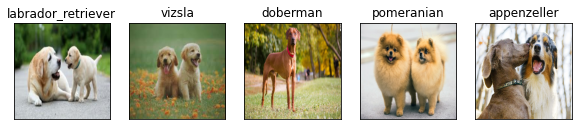

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)
             